In [48]:
!pip install -U sentence-transformers


In [49]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the CSV file
df = pd.read_csv("/content/MTY_Int_Sentiment_Comparation.csv", encoding="latin1")

# Ensure consistent types
df["Number"] = df["Number"].astype(str)
df["respuesta"] = df["respuesta"].astype(str)

# Load the multilingual embedding model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Filter real and generated responses
df_real = df[df["tipo"] == "real"]
df_gen = df[df["tipo"] == "generada"]

# Group responses by question number (concatenate all responses per question)
grouped_real = df_real.groupby("Number")["respuesta"].apply(lambda x: " ".join(x)).reset_index()
grouped_gen = df_gen.groupby("Number")["respuesta"].apply(lambda x: " ".join(x)).reset_index()

# Merge both groups on the question number
df_merged = pd.merge(grouped_real, grouped_gen, on="Number", suffixes=("_real", "_gen"))

# Generate embeddings
emb_real = model.encode(df_merged["respuesta_real"].tolist(), convert_to_tensor=True)
emb_gen = model.encode(df_merged["respuesta_gen"].tolist(), convert_to_tensor=True)


In [50]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Filter to keep only question numbers present in both sets
valid_numbers = set(df_real["Number"]).intersection(set(df_gen["Number"]))
df_valid = df_merged[df_merged["Number"].isin(valid_numbers)].copy()

# Initialize list for similarity scores
similarities = []

# Compute cosine similarity for each valid question
for i, row in df_valid.iterrows():
    try:
        # Generate embeddings
        emb_r = model.encode(row["respuesta_real"], convert_to_tensor=True).unsqueeze(0)
        emb_g = model.encode(row["respuesta_gen"], convert_to_tensor=True).unsqueeze(0)

        # Compute cosine similarity
        sim = cosine_similarity(emb_r.cpu().numpy(), emb_g.cpu().numpy())[0][0]
    except Exception as e:
        sim = None

    similarities.append(sim)

# Add results to the dataframe
df_valid["semantic_similarity"] = similarities

# Display final table
df_valid[["Number", "semantic_similarity"]]


,Number,semantic_similarity
0,1.0,0.283566
1,2.0,0.346277
2,3.0,0.101455
3,4.0,0.252968


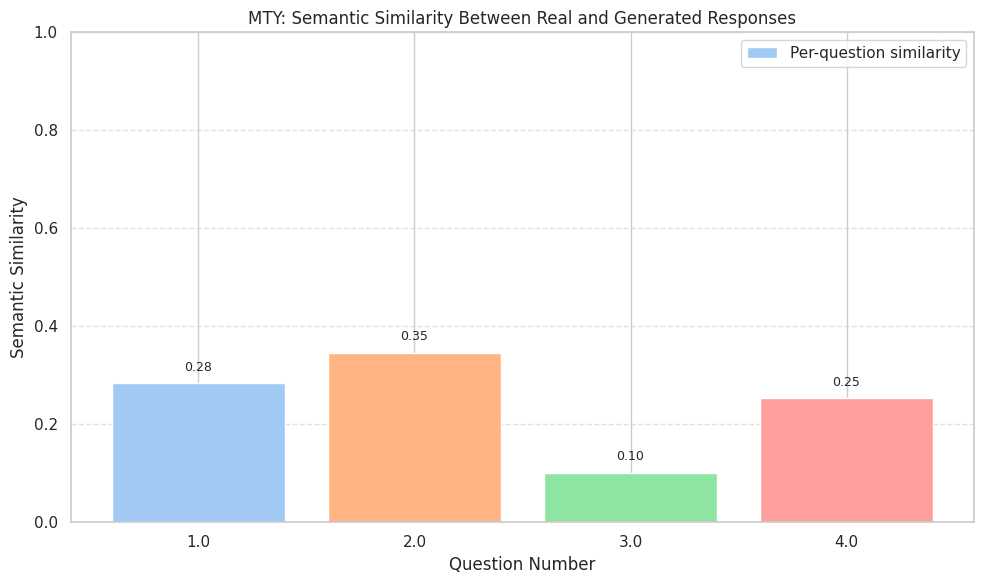

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for consistency
sns.set(style="whitegrid")

# Plot semantic similarity by question
plt.figure(figsize=(10, 6))

# Use different colors, perhaps from the 'pastel' palette
colors = sns.color_palette('pastel', len(df_valid))
plt.bar(
    df_valid["Number"],
    df_valid["semantic_similarity"],
    color=colors,
    label='Per-question similarity'
)

# Add labels and title
plt.title('MTY: Semantic Similarity Between Real and Generated Responses')
plt.xlabel("Question Number")
plt.ylabel("Semantic Similarity")
plt.ylim(0, 1)
plt.xticks(df_valid["Number"])  # ensure integer labels on x-axis
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add text labels on top of bars
for idx, row in df_valid.iterrows():
    plt.text(row["Number"], row["semantic_similarity"] + 0.02,
             f"{row['semantic_similarity']:.2f}",
             ha='center', va='bottom', fontsize=9)

# Show legend and plot
plt.legend()
plt.tight_layout()
plt.show()

# Convert embedding tensors to lists
df_merged["embedding_real"] = [vec.tolist() for vec in emb_real]
df_merged["embedding_gen"] = [vec.tolist() for vec in emb_gen]

# Merge similarity scores from df_valid
df_export = pd.merge(df_merged, df_valid[["Number", "semantic_similarity"]], on="Number", how="left")

# Export to CSV
df_export.to_csv("/content/CDMX_Semantic_Embeddings.csv", index=False)

In [52]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the model (si no lo has cargado antes)
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Asegúrate de tener bien cargado el CSV con los valores correctos
df = pd.read_csv("/content/MTY_Int_Sentiment_Comparation.csv", encoding="latin1")

# Clean and prepare
df["respuesta"] = df["respuesta"].astype(str)
df["Number"] = df["Number"].astype(str)

# Generate embeddings for each response individually
embeddings = model.encode(df["respuesta"].tolist(), convert_to_tensor=False)

# Add them as a new column
df["embedding"] = [e.tolist() for e in embeddings]

# Save the full DataFrame with embeddings
df.to_csv("/content/MTY_AllResponses_withEmbeddings.csv", index=False)


In [53]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load data
df = pd.read_csv('/content/MTY_Int_Sentiment_Comparation.csv', encoding='latin1')
df = df.dropna(subset=['respuesta', 'Number', 'tipo'])
df["respuesta"] = df["respuesta"].astype(str)
df["Number"] = df["Number"].astype(str)

# Load sentence embedding model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

results = []

# Loop over each question
for q in sorted(df['Number'].unique()):
    df_q = df[df['Number'] == q]

    # Get all real responses
    real_responses = df_q[df_q['tipo'] == 'real']['respuesta'].dropna().tolist()

    if len(real_responses) < 2:
        continue  # not enough data to compute reference

    # Create reference embedding for the full set of real responses
    real_reference_text = " ".join(real_responses)
    ref_embedding = model.encode(real_reference_text, convert_to_tensor=True).unsqueeze(0)

    # Compare each generated response to real reference
    for r in df_q[df_q['tipo'] == 'generada']['respuesta'].dropna().tolist():
        emb_r = model.encode(r, convert_to_tensor=True).unsqueeze(0)
        score = cosine_similarity(ref_embedding.cpu().numpy(), emb_r.cpu().numpy())[0][0]
        results.append({'tipo': 'generada', 'pregunta': int(float(q)), 'cosine_semantico': score})

    # Leave-one-out for real responses
    real_list = df_q[df_q['tipo'] == 'real']['respuesta'].dropna().tolist()
    for i, r in enumerate(real_list):
        other_real = real_list[:i] + real_list[i+1:]
        if not other_real:
            continue
        ref_text = " ".join(other_real)
        ref_emb = model.encode(ref_text, convert_to_tensor=True).unsqueeze(0)
        emb_r = model.encode(r, convert_to_tensor=True).unsqueeze(0)
        score = cosine_similarity(ref_emb.cpu().numpy(), emb_r.cpu().numpy())[0][0]
        results.append({'tipo': 'real', 'pregunta': int(float(q)), 'cosine_semantico': score})

# Save and display
df_sem_sim = pd.DataFrame(results)
df_sem_sim.to_csv('/content/semantic_similarity_vs_question_set.csv', index=False)
df_sem_sim.head()


,tipo,pregunta,cosine_semantico
0,generada,1,0.283566
1,generada,1,0.408447
2,generada,1,0.602968
3,generada,1,0.549466
4,generada,1,0.318203


CDMX

/tmp/ipython-input-54-3795003601.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_q_plot, x='tipo', y='cosine_semantico', palette='pastel', ax=ax)
/tmp/ipython-input-54-3795003601.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_q_plot, x='tipo', y='cosine_semantico', palette='pastel', ax=ax)
/tmp/ipython-input-54-3795003601.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_q_plot, x='tipo', y='cosine_semantico', palette='pastel', ax=ax)
/tmp/ipython-input-54-3795003601.py:39: FutureWarning: 

Passing `pale

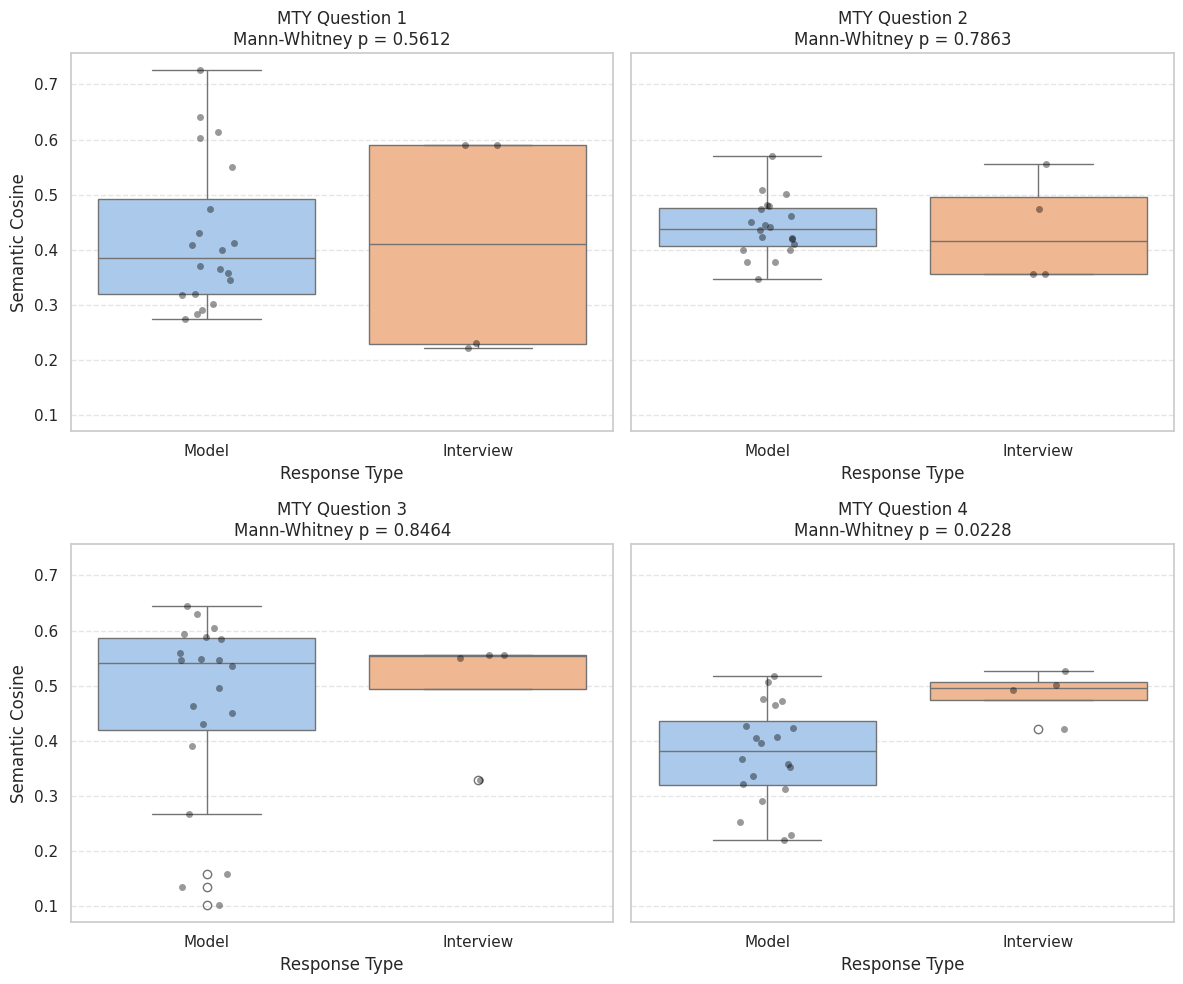


Resultados estadísticos por pregunta:
Pregunta 1: U = 32.00, p = 0.5612 → 🔍 No significativa
Pregunta 2: U = 36.00, p = 0.7863 → 🔍 No significativa
Pregunta 3: U = 43.00, p = 0.8464 → 🔍 No significativa
Pregunta 4: U = 69.00, p = 0.0228 → ✅ SIGNIFICATIVA


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# Get unique question numbers
questions = sorted(df_sem_sim['pregunta'].unique())

# Set up figure for subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten() # Flatten the 2x2 array to easily iterate

# Store results
stat_results = []

# Loop over each question and corresponding axis
for i, q in enumerate(questions):
    ax = axes[i]

    # Filter data for this question
    df_q = df_sem_sim[df_sem_sim['pregunta'] == q]
    real_scores = df_q[df_q['tipo'] == 'real']['cosine_semantico']
    gen_scores = df_q[df_q['tipo'] == 'generada']['cosine_semantico']

    # Mann-Whitney U test
    # Check if there are enough samples in both groups
    if len(real_scores) > 0 and len(gen_scores) > 0:
      u_stat, p_value = mannwhitneyu(real_scores, gen_scores, alternative='two-sided')
    else:
      u_stat, p_value = np.nan, np.nan # Use NaN if not enough data

    stat_results.append({'pregunta': q, 'U': u_stat, 'p_value': p_value})

    # Create a temporary DataFrame with updated labels for plotting
    df_q_plot = df_q.copy()
    df_q_plot['tipo'] = df_q_plot['tipo'].replace({'real': 'Interview', 'generada': 'Model'})

    # Boxplot + stripplot
    sns.boxplot(data=df_q_plot, x='tipo', y='cosine_semantico', palette='pastel', ax=ax)
    sns.stripplot(data=df_q_plot, x='tipo', y='cosine_semantico', color='black', alpha=0.4, ax=ax)

    ax.set_title(f'MTY Question {q}\nMann-Whitney p = {p_value:.4f}' if not np.isnan(p_value) else f'Pregunta {q}\nInsufficient data for test')
    ax.set_xlabel('Response Type')
    ax.set_ylabel('Semantic Cosine' if i % 2 == 0 else '') # Set ylabel only for the left column
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hide any unused subplots
for j in range(len(questions), len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

# Print test results
print("\nResultados estadísticos por pregunta:")
for r in stat_results:
    if not np.isnan(r['p_value']):
        signif = "✅ SIGNIFICATIVA" if r['p_value'] < 0.05 else "🔍 No significativa"
        print(f"Pregunta {r['pregunta']}: U = {r['U']:.2f}, p = {r['p_value']:.4f} → {signif}")
    else:
        print(f"Pregunta {r['pregunta']}: Insufficient data for test")

In [55]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the CSV file
df = pd.read_csv("/content/CDMX_Int_Sentiment_Comparation.csv", encoding="latin1")

# Ensure consistent types
df["Number"] = df["Number"].astype(str)
df["respuesta"] = df["respuesta"].astype(str)

# Load the multilingual embedding model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Filter real and generated responses
df_real = df[df["tipo"] == "real"]
df_gen = df[df["tipo"] == "generada"]

# Group responses by question number (concatenate all responses per question)
grouped_real = df_real.groupby("Number")["respuesta"].apply(lambda x: " ".join(x)).reset_index()
grouped_gen = df_gen.groupby("Number")["respuesta"].apply(lambda x: " ".join(x)).reset_index()

# Merge both groups on the question number
df_merged = pd.merge(grouped_real, grouped_gen, on="Number", suffixes=("_real", "_gen"))

# Generate embeddings
emb_real = model.encode(df_merged["respuesta_real"].tolist(), convert_to_tensor=True)
emb_gen = model.encode(df_merged["respuesta_gen"].tolist(), convert_to_tensor=True)


In [56]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Filter to keep only question numbers present in both sets
valid_numbers = set(df_real["Number"]).intersection(set(df_gen["Number"]))
df_valid = df_merged[df_merged["Number"].isin(valid_numbers)].copy()

# Initialize list for similarity scores
similarities = []

# Compute cosine similarity for each valid question
for i, row in df_valid.iterrows():
    try:
        # Generate embeddings
        emb_r = model.encode(row["respuesta_real"], convert_to_tensor=True).unsqueeze(0)
        emb_g = model.encode(row["respuesta_gen"], convert_to_tensor=True).unsqueeze(0)

        # Compute cosine similarity
        sim = cosine_similarity(emb_r.cpu().numpy(), emb_g.cpu().numpy())[0][0]
    except Exception as e:
        sim = None

    similarities.append(sim)

# Add results to the dataframe
df_valid["semantic_similarity"] = similarities

# Display final table
df_valid[["Number", "semantic_similarity"]]


,Number,semantic_similarity
0,1.0,0.483006
1,2.0,0.155695
2,3.0,0.619091
3,4.0,0.401177


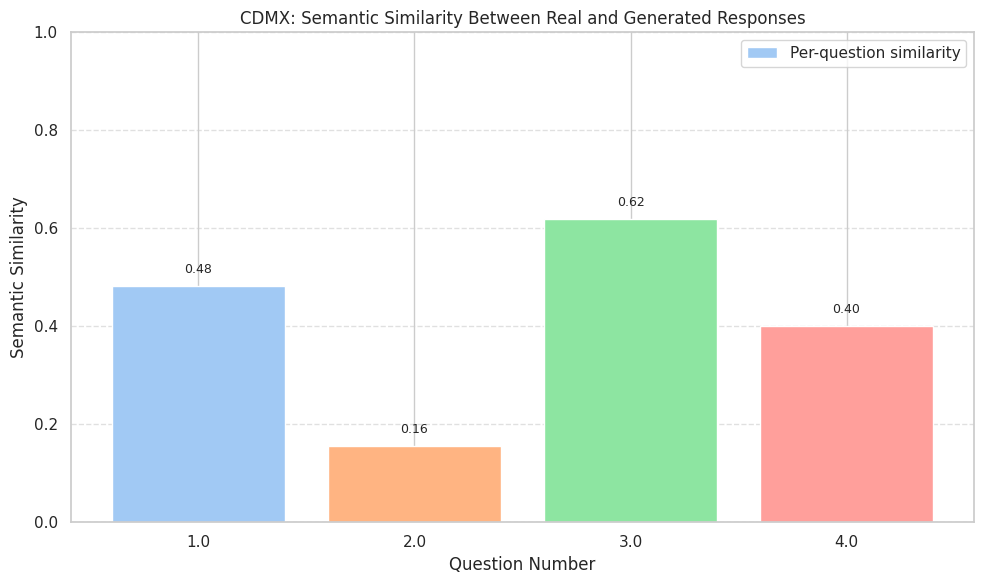

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for consistency
sns.set(style="whitegrid")

# Plot semantic similarity by question
plt.figure(figsize=(10, 6))

# Use different colors, perhaps from the 'pastel' palette
colors = sns.color_palette('pastel', len(df_valid))
plt.bar(
    df_valid["Number"],
    df_valid["semantic_similarity"],
    color=colors,
    label='Per-question similarity'
)


# Add labels and title
plt.title('CDMX: Semantic Similarity Between Real and Generated Responses')
plt.xlabel("Question Number")
plt.ylabel("Semantic Similarity")
plt.ylim(0, 1)
plt.xticks(df_valid["Number"])  # ensure integer labels on x-axis
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add text labels on top of bars
for idx, row in df_valid.iterrows():
    plt.text(row["Number"], row["semantic_similarity"] + 0.02,
             f"{row['semantic_similarity']:.2f}",
             ha='center', va='bottom', fontsize=9)

# Show legend and plot
plt.legend()
plt.tight_layout()
plt.show()

# Convert embedding tensors to lists
df_merged["embedding_real"] = [vec.tolist() for vec in emb_real]
df_merged["embedding_gen"] = [vec.tolist() for vec in emb_gen]

# Merge similarity scores from df_valid
df_export = pd.merge(df_merged, df_valid[["Number", "semantic_similarity"]], on="Number", how="left")

# Export to CSV
df_export.to_csv("/content/CDMX_Semantic_Embeddings.csv", index=False)

In [58]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the model (si no lo has cargado antes)
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Asegúrate de tener bien cargado el CSV con los valores correctos
df = pd.read_csv("/content/CDMX_Int_Sentiment_Comparation.csv", encoding="latin1")

# Clean and prepare
df["respuesta"] = df["respuesta"].astype(str)
df["Number"] = df["Number"].astype(str)

# Generate embeddings for each response individually
embeddings = model.encode(df["respuesta"].tolist(), convert_to_tensor=False)

# Add them as a new column
df["embedding"] = [e.tolist() for e in embeddings]

# Save the full DataFrame with embeddings
df.to_csv("/content/MTY_AllResponses_withEmbeddings.csv", index=False)


In [59]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load data
df = pd.read_csv('/content/CDMX_Int_Sentiment_Comparation.csv', encoding='latin1')
df = df.dropna(subset=['respuesta', 'Number', 'tipo'])
df["respuesta"] = df["respuesta"].astype(str)
df["Number"] = df["Number"].astype(str)

# Load sentence embedding model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

results = []

# Loop over each question
for q in sorted(df['Number'].unique()):
    df_q = df[df['Number'] == q]

    # Get all real responses
    real_responses = df_q[df_q['tipo'] == 'real']['respuesta'].dropna().tolist()

    if len(real_responses) < 2:
        continue  # not enough data to compute reference

    # Create reference embedding for the full set of real responses
    real_reference_text = " ".join(real_responses)
    ref_embedding = model.encode(real_reference_text, convert_to_tensor=True).unsqueeze(0)

    # Compare each generated response to real reference
    for r in df_q[df_q['tipo'] == 'generada']['respuesta'].dropna().tolist():
        emb_r = model.encode(r, convert_to_tensor=True).unsqueeze(0)
        score = cosine_similarity(ref_embedding.cpu().numpy(), emb_r.cpu().numpy())[0][0]
        results.append({'tipo': 'generada', 'pregunta': int(float(q)), 'cosine_semantico': score})

    # Leave-one-out for real responses
    real_list = df_q[df_q['tipo'] == 'real']['respuesta'].dropna().tolist()
    for i, r in enumerate(real_list):
        other_real = real_list[:i] + real_list[i+1:]
        if not other_real:
            continue
        ref_text = " ".join(other_real)
        ref_emb = model.encode(ref_text, convert_to_tensor=True).unsqueeze(0)
        emb_r = model.encode(r, convert_to_tensor=True).unsqueeze(0)
        score = cosine_similarity(ref_emb.cpu().numpy(), emb_r.cpu().numpy())[0][0]
        results.append({'tipo': 'real', 'pregunta': int(float(q)), 'cosine_semantico': score})

# Save and display
df_sem_sim = pd.DataFrame(results)
df_sem_sim.to_csv('/content/semantic_similarity_vs_question_set.csv', index=False)
df_sem_sim.head()


,tipo,pregunta,cosine_semantico
0,generada,1,0.496447
1,generada,1,0.464198
2,generada,1,0.240286
3,generada,1,0.509565
4,generada,1,0.186194


/tmp/ipython-input-60-371520139.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_q_plot, x='tipo', y='cosine_semantico', palette='pastel', ax=ax)
/tmp/ipython-input-60-371520139.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_q_plot, x='tipo', y='cosine_semantico', palette='pastel', ax=ax)
/tmp/ipython-input-60-371520139.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_q_plot, x='tipo', y='cosine_semantico', palette='pastel', ax=ax)
/tmp/ipython-input-60-371520139.py:40: FutureWarning: 

Passing `palette`

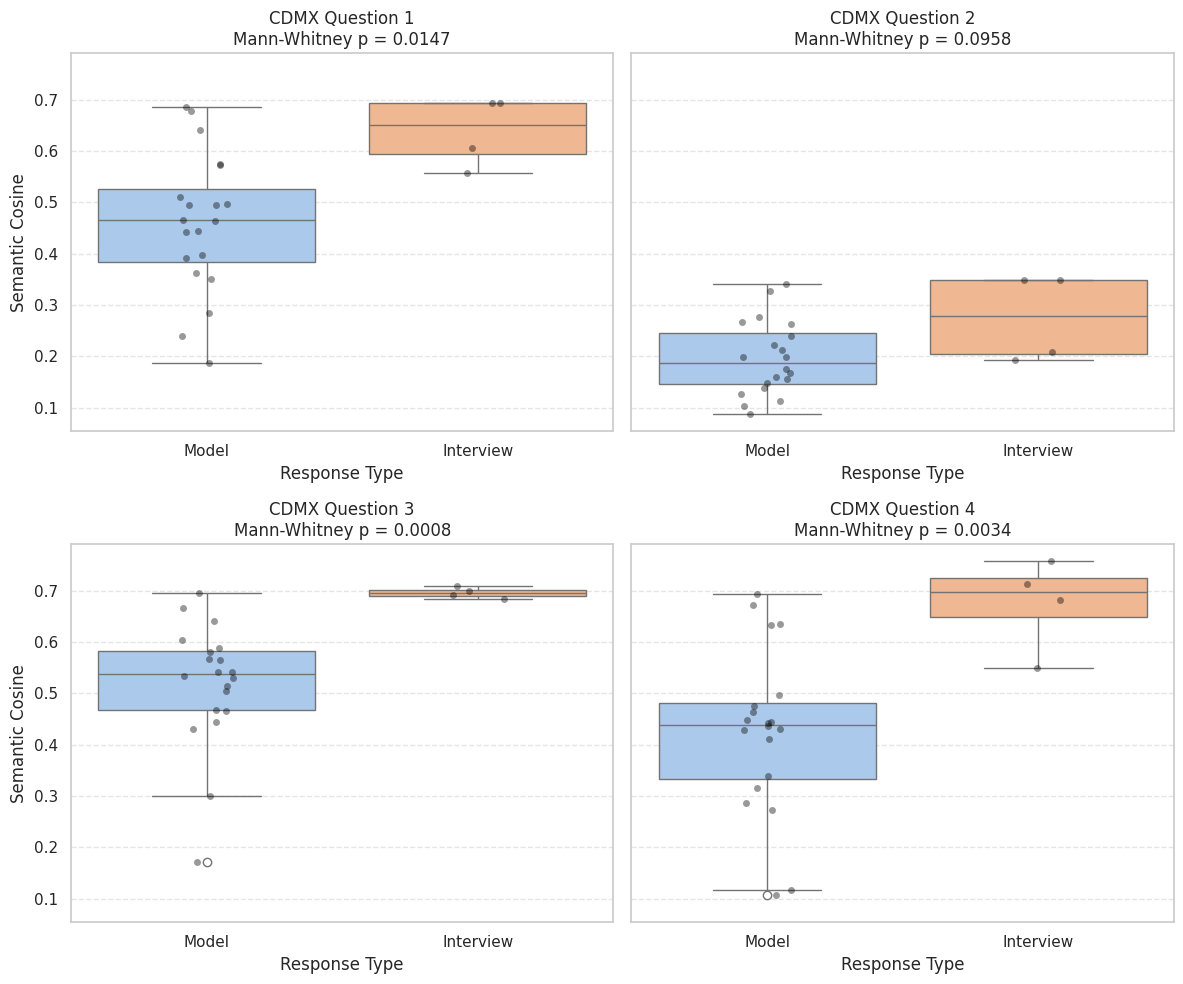


Resultados estadísticos por pregunta:
Pregunta 1: U = 72.00, p = 0.0147 → ✅ SIGNIFICATIVA
Pregunta 2: U = 62.00, p = 0.0958 → 🔍 No significativa
Pregunta 3: U = 78.00, p = 0.0008 → ✅ SIGNIFICATIVA
Pregunta 4: U = 75.00, p = 0.0034 → ✅ SIGNIFICATIVA


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# Get unique question numbers
questions = sorted(df_sem_sim['pregunta'].unique())

# Set up figure for subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten() # Flatten the 2x2 array to easily iterate

# Store results
stat_results = []

# Loop over each question and corresponding axis
for i, q in enumerate(questions):
    ax = axes[i]

    # Filter data for this question
    df_q = df_sem_sim[df_sem_sim['pregunta'] == q]
    real_scores = df_q[df_q['tipo'] == 'real']['cosine_semantico']
    gen_scores = df_q[df_q['tipo'] == 'generada']['cosine_semantico']

    # Mann-Whitney U test
    # Check if there are enough samples in both groups
    if len(real_scores) > 0 and len(gen_scores) > 0:
      u_stat, p_value = mannwhitneyu(real_scores, gen_scores, alternative='two-sided')
    else:
      u_stat, p_value = np.nan, np.nan # Use NaN if not enough data

    stat_results.append({'pregunta': q, 'U': u_stat, 'p_value': p_value})

    # Create a temporary DataFrame with updated labels for plotting
    df_q_plot = df_q.copy()
    df_q_plot['tipo'] = df_q_plot['tipo'].replace({'real': 'Interview', 'generada': 'Model'})


    # Boxplot + stripplot
    sns.boxplot(data=df_q_plot, x='tipo', y='cosine_semantico', palette='pastel', ax=ax)
    sns.stripplot(data=df_q_plot, x='tipo', y='cosine_semantico', color='black', alpha=0.4, ax=ax)

    ax.set_title(f'CDMX Question {q}\nMann-Whitney p = {p_value:.4f}' if not np.isnan(p_value) else f'Pregunta {q}\nInsufficient data for test')
    ax.set_xlabel('Response Type')
    ax.set_ylabel('Semantic Cosine' if i % 2 == 0 else '') # Set ylabel only for the left column
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hide any unused subplots
for j in range(len(questions), len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

# Print test results
print("\nResultados estadísticos por pregunta:")
for r in stat_results:
    if not np.isnan(r['p_value']):
        signif = "✅ SIGNIFICATIVA" if r['p_value'] < 0.05 else "🔍 No significativa"
        print(f"Pregunta {r['pregunta']}: U = {r['U']:.2f}, p = {r['p_value']:.4f} → {signif}")
    else:
        print(f"Pregunta {r['pregunta']}: Insufficient data for test")